<a href="https://colab.research.google.com/github/adrnabrm/traffic-prediction-GCNLSTM/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traffic forecasting using GCN-LSTM
Adrian Abraham <br>
CECS 456

## Installing necessary libraries

In [1]:
!pip install torch-geometric tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.6 MB/s eta 0:00:00


# Importing data
We use the METR-LA dataset from Kaggle

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("annnnguyen/metr-la-dataset")

print("Path to dataset files:", path)

100%|██████████| 12.5M/12.5M [00:01<00:00, 7.88MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/annnnguyen/metr-la-dataset/versions/4


Loading sensor speed and proximity data

In [3]:
import pickle

# loading graph data
with open(f'{path}/adj_METR-LA.pkl', 'rb') as f:
    graph_data = pickle.load(f, encoding='latin1')

# graph data conains the sensor ids that map to node ids, and the adjacency matrix for spatial information of the data
sensor_ids = graph_data[0]
node_ids   = graph_data[1]
adj_matrix = graph_data[2]

In [4]:
import pandas as pd

df = pd.read_hdf(f'{path}/METR-LA.h5', key='df')

Using linear interpolation to fill in missing values

In [5]:
import numpy as np

# replacing all missing values, denoted as 0.0, to np.nan for imputation
df.replace(0.0, np.nan, inplace=True)

# linear interpolation
df_imputed = df.interpolate(method='linear', limit_direction='both')
df_imputed = df_imputed.bfill().ffill()

# takes the index information from the previous df and applies it to the new one
df_imputed.index = df.index

# Set the frequency manually if it's uniform (e.g., 5 minutes)
df_imputed.index = pd.to_datetime(df_imputed.index)  # Ensure the index is of datetime type
df_imputed = df_imputed.asfreq('5min')  # Set frequency to 5 minutes (adjust as needed)

df_imputed.head()

,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
2012-03-01 00:00:00,64.375000,67.625000,67.125000,61.500000,66.875000,68.750000,65.125000,67.125000,59.625000,62.750000,...,45.625000,65.500000,64.500000,66.428571,66.875000,59.375000,69.000000,59.250000,69.000000,61.875000
2012-03-01 00:05:00,62.666667,68.555556,65.444444,62.444444,64.444444,68.111111,65.000000,65.000000,57.444444,63.333333,...,50.666667,69.875000,66.666667,58.555556,62.000000,61.111111,64.444444,55.888889,68.444444,62.875000
2012-03-01 00:10:00,64.000000,63.750000,60.000000,59.000000,66.500000,66.250000,64.500000,64.250000,63.875000,65.375000,...,44.125000,69.000000,56.500000,59.250000,68.125000,62.500000,65.625000,61.375000,69.857143,62.000000
2012-03-01 00:15:00,61.777778,65.500000,62.555556,59.888889,66.777778,67.166667,63.222222,65.277778,63.583333,64.694444,...,43.416667,69.333333,60.444444,58.611111,67.416667,59.888889,65.305556,60.138889,69.571429,60.444444
2012-03-01 00:20:00,59.555556,67.250000,65.111111,60.777778,67.055556,68.083333,61.944444,66.305556,63.291667,64.013889,...,42.708333,69.666667,64.388889,57.972222,66.708333,57.277778,64.986111,58.902778,69.285714,58.888889


# Data visualization

Visualization of speed over time of a few of the sensors

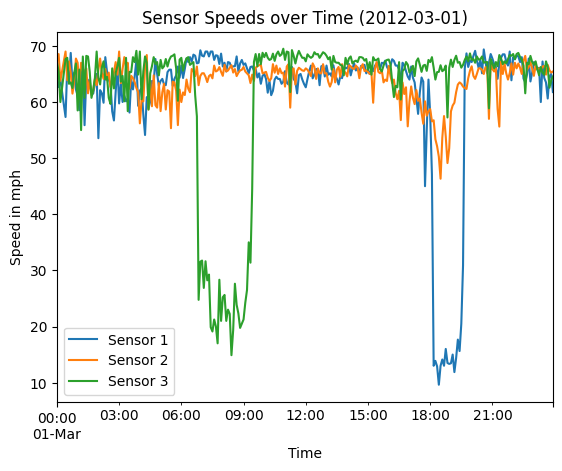

In [6]:
import matplotlib.pyplot as plt

# example portion of the data
df_imputed.iloc[0:288, 0].plot()
df_imputed.iloc[0:288, 1].plot()
df_imputed.iloc[0:288, 2].plot()
plt.legend(['Sensor 1', 'Sensor 2', 'Sensor 3'])
plt.xlabel('Time')
plt.ylabel('Speed in mph')
plt.title('Sensor Speeds over Time (2012-03-01)')
plt.show()

Visualizing how the sensors relate to each other, these are the first 30 nodes

<Axes: >

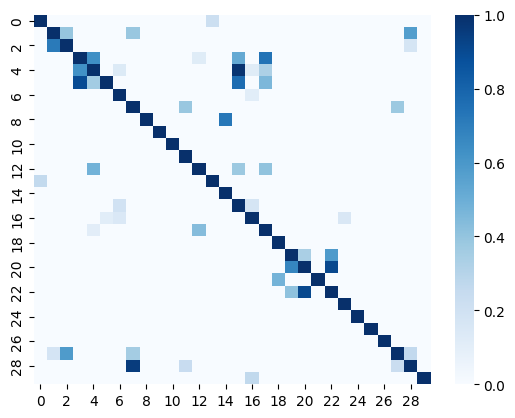

In [7]:
import seaborn as sns

# showing how each sensor is related to each other, we can see that Node 3 and 5 are correlated with each other, but Node 0 and 2 arent correlated at all
sns.heatmap(adj_matrix[:30, :30], cmap='Blues')

# Dataset creation

To create the dataset, we use a history of 12 time steps of 5 minutes to predict the next 3 time steps also of 5 minutes

In [8]:
def create_dataset(df, history=12, horizon=3):
  data = df.values
  X, y = [], []
  # using sliding window technique to get a data point that's history size long (12 * 5 = 60 mins)
  # maps it to the future window of horizon long (in this case 3 * 5 = 15 mins)
  for t in range(len(data) - history - horizon + 1):
    x_t = data[t:t+history]
    y_t = data[t+history:t+history+horizon]
    X.append(x_t)
    y.append(y_t)
  return np.array(X), np.array(y)

X, y = create_dataset(df_imputed)
print(f'X shape: {X.shape}, y shape: {y.shape}')

X shape: (34258, 12, 207), y shape: (34258, 3, 207)


Taking the adjacency matrix from the METR-LA dataset to format into proper PyTorch Geometric (PyG) format

In [9]:
import torch

# getting the indices of non-zero elements, this is where there are edges
source_nodes, target_nodes = np.where(adj_matrix > 0)

# turning into an index, which defines structure of the graph
edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)

# keeping track the weight of each edge
edge_attr = torch.tensor(adj_matrix[source_nodes, target_nodes], dtype=torch.float).unsqueeze(1)

<ipython-input-9-1d406eb05b80>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)


We wrap the dataset into a Dataset class to be compatible with PyG and GCNs

In [10]:
from torch.utils.data import Dataset
from torch_geometric.data import Data

class TrafficDataset(Dataset):
  def __init__(self, X, y, edge_index, edge_attr):
    self.X = torch.tensor(X, dtype=torch.float32) # Shape: (num_samples, historical time steps (12), num_nodes)
    self.y = torch.tensor(y, dtype=torch.float32) # Shape: (num_samples, horizon time steps (3), num_nodes)
    self.edge_index = edge_index
    self.edge_attr = edge_attr

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    x_seq = self.X[idx] # Shape: (12, 207)
    y_seq = self.y[idx] # Shape: (3, 207)

    # creating Data objects for each timestep
    data_list = []
    for t in range(x_seq.shape[0]):
      # 207 sensors, 1 feature (speed), to give us shape of (207,1)
      # x_t was originally (207,)
      # this is so that it is compatible with the GCN
      x_t = x_seq[t].unsqueeze(1)
      data = Data(x=x_t, edge_index=self.edge_index, edge_attr=self.edge_attr)
      data_list.append(data)

    # data_list list of 12 (207,1) objs
    # y_seq.shape(3,207)
    return data_list, y_seq

Splitting data into train, val, and test splits

In [11]:
import copy

# this deep copy will not be scaled and used for the baseline model
X_orig = copy.deepcopy(X)
y_orig = copy.deepcopy(y)

In [12]:
from sklearn.preprocessing import StandardScaler

def train_val_test_split(X, y, val_ratio=0.1, test_ratio=0.1,scale=True):
  train_size = int(len(X) * (1 - val_ratio - test_ratio))
  val_size = int(len(X) * val_ratio)
  test_size = len(X) - train_size - val_size
  x_scaler, y_scaler = None, None
  if scale:
    # StandardScaler expects dimension of 2 (X is currently dim=3)
    # we can flatten each of the samples from (12,207) to one dimension
    X_reshaped = X.reshape(X.shape[0], -1)

    x_scaler = StandardScaler()
    # using the training set to scale, and using those values to transform val and train set
    X_reshaped[:train_size] = x_scaler.fit_transform(X_reshaped[:train_size])
    X_reshaped[train_size:train_size+val_size] = x_scaler.transform(X_reshaped[train_size:train_size+val_size])
    X_reshaped[train_size+val_size:] = x_scaler.transform(X_reshaped[train_size+val_size:])

    # reshaping back to the original shape
    X = X_reshaped.reshape(X.shape)

    y_reshaped = y.reshape(y.shape[0], -1)
    y_scaler = StandardScaler()
    y_reshaped[:train_size] = y_scaler.fit_transform(y_reshaped[:train_size])
    y_reshaped[train_size:train_size+val_size] = y_scaler.transform(y_reshaped[train_size:train_size+val_size])
    y_reshaped[train_size+val_size:] = y_scaler.transform(y_reshaped[train_size+val_size:])
    y = y_reshaped.reshape(y.shape)

  # splitting the dataset using the different sizes
  train = TrafficDataset(X[:train_size], y[:train_size], edge_index, edge_attr)
  val = TrafficDataset(X[train_size:train_size+val_size], y[train_size:train_size+val_size], edge_index, edge_attr)
  test = TrafficDataset(X[train_size+val_size:], y[train_size+val_size:], edge_index, edge_attr)

  print(f"Train size: {len(train)}")
  print(f"Validation size: {len(val)}")
  print(f"Test size: {len(test)}")

  return train, val, test, x_scaler if x_scaler else None, y_scaler if y_scaler else None

train, val, test, x_scaler, y_scaler= train_val_test_split(X,y)

Train size: 27406
Validation size: 3425
Test size: 3427


We use DataLoader to split the dataset into batches for mini-batch SGD

In [13]:
# default PyTorch cannot collate PyG Data objects
# we define this here
# we are putting the x_seq's into a list called x_seq_batch
# and since y is a torch.tensor, we can stack each y instance using torch
def collate_fn(batch):
    x_seq_batch = [item[0] for item in batch]  # List of batch_size (128) sequences of 12 Data objects
    y_batch = torch.stack([item[1] for item in batch])  # Stack the target tensors

    # y_seq.shape = (128, 3, 207)
    return x_seq_batch, y_batch

In [14]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val, batch_size=128, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test, batch_size=128, shuffle=False, collate_fn=collate_fn)

# Baseline model: Historical Average
Predicting speeds based off of past averages

In [15]:
from sklearn.model_selection import train_test_split

# X, y = shape (N, 12, 207) and (N, 3, 207)
X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=0.2, shuffle=False)

# compute average across training targets (axis=0 and 1: over time + samples)
historical_avg = y_train.mean(axis=(0, 1))  # shape (207,)

# broadcast to shape (test_size, 3, 207)
baseline_preds = np.tile(historical_avg, (y_test.shape[0], y_test.shape[1], 1))

# compute metrics
mae = np.mean(np.abs(baseline_preds - y_test))
rmse = np.sqrt(np.mean((baseline_preds - y_test) ** 2))
mape = np.mean(np.abs((baseline_preds - y_test) / (y_test + 1e-5))) * 100

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")

MAE: 7.5228
RMSE: 11.7909
MAPE: 24.5096


MAE: the model is off by ~7.5 mph per prediction <br>
RMSE: large errors exist <br>
MAPE: predictions are off by around ~24.5% on average relative to ground truth <br>

Visualizing the predictions with the ground truth

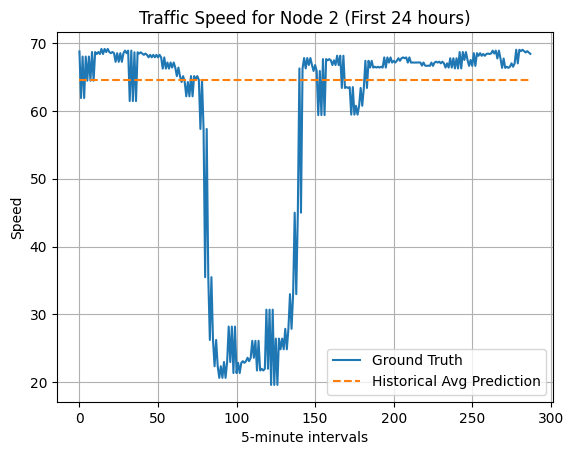

(20556, 207) (20556, 207)


In [16]:
import matplotlib.pyplot as plt

# Choose a node index (e.g., node 0)
node_idx = 2

# Flatten y_test and baseline_preds to shape (num_samples * 3, 207)
# So we can extract all 3-step ahead predictions per sample
y_flat = y_test.reshape(-1, 207)
preds_flat = baseline_preds.reshape(-1, 207)

# Select values for one node
y_node = y_flat[:, node_idx]
preds_node = preds_flat[:, node_idx]

plt.plot(y_node[:288], label="Ground Truth")
plt.plot(preds_node[:288], label="Historical Avg Prediction", linestyle="--")
plt.title(f"Traffic Speed for Node {node_idx} (First 24 hours)")
plt.xlabel("5-minute intervals")
plt.ylabel("Speed")
plt.legend()
plt.grid(True)
plt.show()

print(y_flat.shape, preds_flat.shape)

# LSTM Model

In [17]:
def compute_metrics(preds, targets, inverser_scale=True):

  with torch.no_grad():
        preds_batch_size = preds.shape[0]

        # preds and targets shape: (batch, num_nodes, horizon)
        # reshape to 2D (batch, features) for the scaler
        # transpose() is like permute()
        preds_np = preds.cpu().numpy().transpose(0, 2, 1).reshape(-1, 3 * 207)
        targets_np = targets.cpu().numpy().transpose(0, 2, 1).reshape(-1, 3 * 207)

        # inverse transform using fitted y_scaler
        preds_inv = y_scaler.inverse_transform(preds_np).reshape(-1, 3, 207).transpose(0, 2, 1)
        targets_inv = y_scaler.inverse_transform(targets_np).reshape(-1, 3, 207).transpose(0, 2, 1)

        mae  = np.mean(np.abs(preds_inv - targets_inv)) * preds_batch_size
        rmse = np.sqrt(np.mean((preds_inv - targets_inv)**2)) * preds_batch_size
        mape = np.mean(np.abs((preds_inv - targets_inv) / (targets_inv + 1e-5))) * 100 * preds_batch_size

        return mae, rmse, mape, preds_batch_size


In [18]:
from torch import nn
from torch_geometric.data import Batch

class LSTMModel(nn.Module):
  def __init__(self):
      super(LSTMModel, self).__init__()

      self.lstm = nn.LSTM(
        input_size=1,
        hidden_size=128,
        num_layers=4,
        dropout=0.2,
        batch_first=True
      )

      self.fc = nn.Linear(128, 3)

  def forward(self, x):
      # x shape: (batch_size, seq_len, num_nodes, input_dim)
      batch_size, seq_len, num_nodes, input_dim = x.shape

      # Reshape to (batch_size * num_nodes, seq_len, input_dim)
      x = x.permute(0, 2, 1, 3).reshape(batch_size * num_nodes, seq_len, input_dim)

      # LSTM over time
      lstm_out, _ = self.lstm(x)  # shape: (B*N, seq_len, hidden_dim)
      last_hidden = lstm_out[:, -1, :]  # shape: (B*N, hidden_dim)

      out = self.fc(last_hidden)  # shape: (B*N, 3)

      # Reshape back to (batch_size, num_nodes, 3)
      out = out.view(batch_size, num_nodes, 3)
      return out


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 10
basemodel = LSTMModel().to(device)
#basemodel.load_state_dict(torch.load()) # for loading in saved models
criterion = nn.MSELoss()
# Adam with L2 regularization
optimizer = torch.optim.Adam(basemodel.parameters(), lr=0.005, weight_decay=1e-5)
scheduler = ExponentialLR(optimizer, gamma=0.95)

train_history = {
    "loss": [],
    "mae": [],
    "rmse": [],
    "mape": [],
}

val_history = {
    "loss": [],
    "mae": [],
    "rmse": [],
    "mape": [],
}

print(basemodel)

LSTMModel(
  (lstm): LSTM(1, 128, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)


In [23]:
best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0
early_stop = False


for epoch in range(num_epochs):
    basemodel.train()
    train_loss = train_mae = train_rmse = train_mape = train_samples = 0

    train_loader_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=True)

    for data_batch, target_batch in train_loader_bar:
        batch_size = len(data_batch)
        seq_len = len(data_batch[0])
        num_nodes = data_batch[0][0].num_nodes
        input_dim = data_batch[0][0].x.shape[1]

        # Create input tensor: (B, T, N, F)
        x_tensor = torch.zeros(batch_size, seq_len, num_nodes, input_dim).to(device)
        for b_idx, seq in enumerate(data_batch):
            for t_idx, graph in enumerate(seq):
                x_tensor[b_idx, t_idx] = graph.x.to(device)

        targets = target_batch.to(device).permute(0, 2, 1)  # (B, N, 3)

        # Just move to device — leave x_tensor as 4D
        x_tensor = x_tensor.to(device)  # shape: (B, T, N, F)

        # Forward pass
        preds = basemodel(x_tensor)  # model reshapes internally

        loss = criterion(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        with torch.no_grad():
            mae, rmse, mape, preds_batch_size = compute_metrics(preds, targets)
            train_mae += mae
            train_rmse += rmse
            train_mape += mape
            train_samples += preds_batch_size

    # ----- Validation -----
    basemodel.eval()
    val_loss = val_mae = val_rmse = val_mape = val_samples = 0

    val_loader_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=True)

    with torch.no_grad():
        for data_batch, target_batch in val_loader_bar:
            batch_size = len(data_batch)
            seq_len = len(data_batch[0])
            num_nodes = data_batch[0][0].num_nodes
            input_dim = data_batch[0][0].x.shape[1]

            x_tensor = torch.zeros(batch_size, seq_len, num_nodes, input_dim).to(device)
            for b_idx, seq in enumerate(data_batch):
                for t_idx, graph in enumerate(seq):
                    x_tensor[b_idx, t_idx] = graph.x.to(device)

            targets = target_batch.to(device).permute(0, 2, 1)  # (B, N, 3)
            # Just move to device — leave x_tensor as 4D
            x_tensor = x_tensor.to(device)  # shape: (B, T, N, F)

            # Forward pass
            preds = basemodel(x_tensor)  # model reshapes internally


            loss = criterion(preds, targets)
            val_loss += loss.item()

            mae, rmse, mape, preds_batch_size = compute_metrics(preds, targets)
            val_mae += mae
            val_rmse += rmse
            val_mape += mape
            val_samples += preds_batch_size

    # ----- Logging -----
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_history['loss'].append(avg_train_loss)
    train_history['mae'].append(train_mae / train_samples)
    train_history['rmse'].append(train_rmse / train_samples)
    train_history['mape'].append(train_mape / train_samples)

    val_history['loss'].append(avg_val_loss)
    val_history['mae'].append(val_mae / val_samples)
    val_history['rmse'].append(val_rmse / val_samples)
    val_history['mape'].append(val_mape / val_samples)

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Optionally save model
        torch.save(basemodel.state_dict(), "LSTM.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            early_stop = True
            break


    scheduler.step()

    print()
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")
    print(f"Train MAE: {train_mae / train_samples:.4f} - Train RMSE: {train_rmse / train_samples:.4f} - Train MAPE: {train_mape / train_samples:.4f}")
    print(f"Val MAE: {val_mae / val_samples:.4f} - Val RMSE: {val_rmse / val_samples:.4f} - Val MAPE: {val_mape / val_samples:.4f}")
    print()


Epoch 1/10 [Val]: 100%|██████████| 27/27 [00:04<00:00,  5.41it/s]



Epoch 1/10 - Train Loss: 0.3193 - Val Loss: 0.3127
Train MAE: 2.9913 - Train RMSE: 5.3047 - Train MAPE: 7.7770
Val MAE: 2.9500 - Val RMSE: 5.1224 - Val MAPE: 8.5237



Epoch 2/10 [Val]: 100%|██████████| 27/27 [00:04<00:00,  5.47it/s]



Epoch 2/10 - Train Loss: 0.2762 - Val Loss: 0.3021
Train MAE: 2.7009 - Train RMSE: 4.8875 - Train MAPE: 6.8220
Val MAE: 2.8505 - Val RMSE: 4.9894 - Val MAPE: 8.0609



Epoch 3/10 [Val]: 100%|██████████| 27/27 [00:05<00:00,  5.26it/s]



Epoch 3/10 - Train Loss: 0.2728 - Val Loss: 0.3093
Train MAE: 2.6766 - Train RMSE: 4.8495 - Train MAPE: 6.7383
Val MAE: 2.8270 - Val RMSE: 5.0856 - Val MAPE: 7.2823



Epoch 4/10 [Val]: 100%|██████████| 27/27 [00:04<00:00,  5.48it/s]



Epoch 4/10 - Train Loss: 0.2707 - Val Loss: 0.2963
Train MAE: 2.6583 - Train RMSE: 4.8318 - Train MAPE: 6.6823
Val MAE: 2.8438 - Val RMSE: 4.9312 - Val MAPE: 7.4196



Epoch 5/10 [Val]: 100%|██████████| 27/27 [00:04<00:00,  5.46it/s]



Epoch 5/10 - Train Loss: 0.2696 - Val Loss: 0.2952
Train MAE: 2.6483 - Train RMSE: 4.8197 - Train MAPE: 6.6444
Val MAE: 2.7526 - Val RMSE: 4.9180 - Val MAPE: 7.4258



Epoch 6/10 [Val]: 100%|██████████| 27/27 [00:04<00:00,  5.48it/s]



Epoch 6/10 - Train Loss: 0.2697 - Val Loss: 0.2971
Train MAE: 2.6521 - Train RMSE: 4.8222 - Train MAPE: 6.6543
Val MAE: 2.9622 - Val RMSE: 4.9559 - Val MAPE: 7.9025



Epoch 7/10 [Val]: 100%|██████████| 27/27 [00:04<00:00,  5.44it/s]



Epoch 7/10 - Train Loss: 0.2701 - Val Loss: 0.3070
Train MAE: 2.6537 - Train RMSE: 4.8209 - Train MAPE: 6.6631
Val MAE: 2.9891 - Val RMSE: 5.0725 - Val MAPE: 8.7332



Epoch 8/10 [Val]: 100%|██████████| 27/27 [00:04<00:00,  5.48it/s]



Epoch 8/10 - Train Loss: 0.2688 - Val Loss: 0.2963
Train MAE: 2.6369 - Train RMSE: 4.8076 - Train MAPE: 6.6115
Val MAE: 2.7579 - Val RMSE: 4.9244 - Val MAPE: 7.6079



Epoch 9/10 [Val]: 100%|██████████| 27/27 [00:04<00:00,  5.44it/s]



Epoch 9/10 - Train Loss: 0.2689 - Val Loss: 0.2933
Train MAE: 2.6371 - Train RMSE: 4.8061 - Train MAPE: 6.6111
Val MAE: 2.7562 - Val RMSE: 4.8990 - Val MAPE: 7.1055



Epoch 10/10 [Val]: 100%|██████████| 27/27 [00:04<00:00,  5.44it/s]


Epoch 10/10 - Train Loss: 0.2691 - Val Loss: 0.3033
Train MAE: 2.6333 - Train RMSE: 4.8045 - Train MAPE: 6.5992
Val MAE: 2.8276 - Val RMSE: 4.9980 - Val MAPE: 7.1460



Processing batch...: 100%|██████████| 27/27 [00:05<00:00,  5.29it/s]


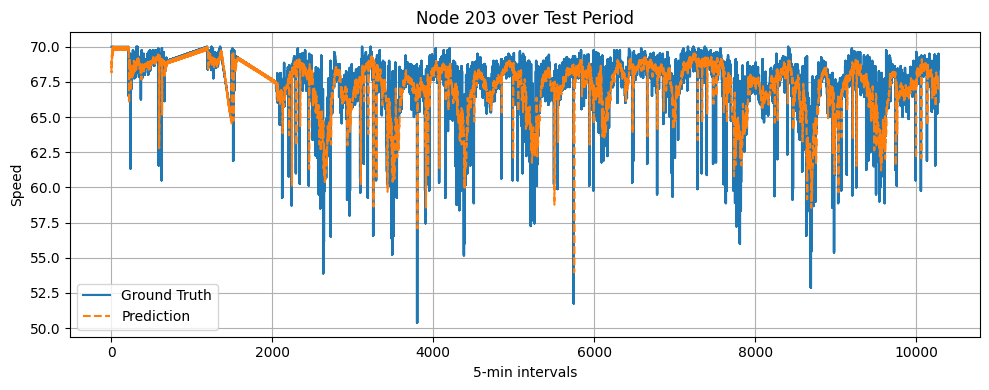

MAE: 2.5425  RMSE: 4.6382  MAPE: 6.2017


In [27]:
def test_metrics(test_loader):
    basemodel.eval()

    total_mae = 0
    total_rmse = 0
    total_mape = 0
    samples = 0

    all_preds = []
    all_targs = []

    with torch.no_grad():
        for data_batch, target_batch in tqdm(test_loader, desc="Processing batch..."):
            # prepare and predict
            batch_size = len(data_batch)
            seq_len = len(data_batch[0])
            num_nodes = data_batch[0][0].num_nodes
            input_dim = data_batch[0][0].x.shape[1]

            x_tensor = torch.zeros(batch_size, seq_len, num_nodes, input_dim).to(device)
            for b_idx, seq in enumerate(data_batch):
                for t_idx, graph in enumerate(seq):
                    x_tensor[b_idx, t_idx] = graph.x.to(device)

            targs = target_batch.to(device).permute(0, 2, 1)  # shape: (B, 207, 3)
            preds = basemodel(x_tensor)  # shape: (B, 207, 3)


            # metrics
            mae, rmse, mape, b = compute_metrics(preds, targs)
            total_mae  += mae
            total_rmse += rmse
            total_mape += mape
            samples += b

            all_preds.append(preds.cpu())
            all_targs.append(targs.cpu())

    # concatenate full test set
    preds = torch.cat(all_preds, dim=0).numpy()   # (N,207,3)
    targs = torch.cat(all_targs, dim=0).numpy()  # (N,207,3)

    # bring horizon into axis=1, flatten for scaler if needed:
    flat_preds = preds.transpose(0,2,1).reshape(-1, 3*207)   # (N*3,207)
    flat_targs = targs.transpose(0,2,1).reshape(-1, 3*207)

    # inverse scale here if you uncomment:
    flat_preds = y_scaler.inverse_transform(flat_preds)
    flat_targs = y_scaler.inverse_transform(flat_targs)

    # reshape back to (N,207,3)
    up_preds = flat_preds.reshape(-1,3,207).transpose(0,2,1)
    up_targs = flat_targs.reshape(-1,3,207).transpose(0,2,1)

    # finally flatten into continuous series: (N,207,3) -> (N*3,207)
    preds_flat = up_preds.transpose(0,2,1).reshape(-1,207)
    targs_flat = up_targs.transpose(0,2,1).reshape(-1,207)

    # plot sensor
    node = 203
    plt.figure(figsize=(10,4))
    plt.plot(targs_flat[:, node], label="Ground Truth")
    plt.plot(preds_flat[:, node], '--', label="Prediction")
    plt.title(f"Node {node} over Test Period")
    plt.xlabel("5-min intervals")
    plt.ylabel("Speed")
    plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.show()

    return total_mae/samples, total_rmse/samples, total_mape/samples

mae, rmse, mape = test_metrics(test_loader)
print(f"MAE: {mae:.4f}  RMSE: {rmse:.4f}  MAPE: {mape:.4f}")


# Spatiotemporal Model: GCNLSTM Model

In [17]:
from torch import nn
from torch_geometric.nn import GCNConv
from torch_geometric.data import Batch

class TrafficForecastingModel(nn.Module):
    def __init__(self):
        super(TrafficForecastingModel, self).__init__()

        self.gcn1 = GCNConv(1, 32)
        self.relu1 = nn.ReLU()

        self.gcn2 = GCNConv(32, 64)
        self.dropout = nn.Dropout(p=0.2)
        self.relu2 = nn.ReLU()

        self.gcn3 = GCNConv(64, 64)
        self.relu3 = nn.ReLU()

        self.lstm = nn.LSTM(
            input_size=64,
            hidden_size=128,
            num_layers=4,
            dropout=0.2,
            batch_first=True
        )

        self.fc = nn.Linear(128, 3)

    def forward(self, batched_graphs, batch_size):
        # batched_graphs contains all (batch_size * 12) graphs
        x, edge_index, edge_attr = batched_graphs.x, batched_graphs.edge_index, batched_graphs.edge_attr

        # GCN layers over the mega batch
        x = self.gcn1(x, edge_index, edge_weight=edge_attr)

        # dropout 20% of neurons randomly
        x = self.dropout(x)
        x = self.relu1(x)

        x = self.gcn2(x, edge_index, edge_weight=edge_attr)
        x = self.relu2(x)

        # residual GCN layer (GCN3 + skip connection from GCN2 output)
        res = x
        x = self.gcn3(x, edge_index, edge_weight=edge_attr)
        x = self.relu3(x + res)

        # split GCN outputs into 12 chunks (timesteps)
        num_nodes = 207
        seq_len = 12
        gcn_out_dim = 64

        # x.shape = (64 * 12 * 207, 64)
        # we need to reshape (64, 12, 207, 64)
        # view() will reshape accordingly since order of everything was preserved
        x = x.view(batch_size, seq_len, num_nodes, gcn_out_dim)

        # rearrange for LSTM: (batch_size * num_nodes, seq_len, gcn_out_dim)
        # this is because LSTM expects (num_nodes (generally called batch), seq_len, input_features)
        # as we want to treat each node as a separate sequence

        # we then reshape for forwarding a whole batch
        x = x.permute(0, 2, 1, 3)
        x = x.reshape(batch_size * num_nodes, seq_len, gcn_out_dim)

        # now can pass each x with 12 time instances through LSTM
        # with each time instance, we use the same LSTM unit, creating 12 hidden states
        lstm_out, _ = self.lstm(x)  # shape: (128 * 207, 12, 128)

        # the last hidden state summarizes the entire sequence,
        # as it has been updated at each time step using previous hidden states
        # it captures the temporal context up to the final time step
        last_hidden = lstm_out[:, -1, :]  # (128 * 207, 128)

        # dropout 0.2
        last_hidden = self.dropout(last_hidden)
        # final pass through fully connected output, reshape to (128, 207, 3)
        out = self.fc(last_hidden)
        out = out.view(batch_size, num_nodes, -1)

        return out  # shape: (128, 207, 3)


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 25
model = TrafficForecastingModel().to(device)
model.load_state_dict(torch.load("GCNLSTMTrained.pt")) # for loading in saved models
criterion = nn.MSELoss()
# Adam with L2 regularization
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)
scheduler = ExponentialLR(optimizer, gamma=0.95)

train_history = {
    "loss": [],
    "mae": [],
    "rmse": [],
    "mape": [],
}

val_history = {
    "loss": [],
    "mae": [],
    "rmse": [],
    "mape": [],
}

print(model)

TrafficForecastingModel(
  (gcn1): GCNConv(1, 32)
  (relu1): ReLU()
  (gcn2): GCNConv(32, 64)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu2): ReLU()
  (gcn3): GCNConv(64, 64)
  (relu3): ReLU()
  (lstm): LSTM(64, 128, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)


Training loop

In [ ]:
from torch_geometric.data import Batch

# training loop
for epoch in range(num_epochs):
    model.train()
    train_mae = 0
    train_rmse = 0
    train_mape = 0
    train_samples = 0
    train_loss = 0

    # visualizes a loading bar while batching train loader
    training_loader_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=True)

    for data_batch, target_batch in training_loader_bar:
        # recall: data_batch is a list of 128 sequences of 12 Data objs
        # we flatten all graphs across batch and time: (batch_size * seq_len)
        # in this case (128 * 12)
        all_graphs = [] # final list will have (128 * 12) Data objs
        for x_seq in data_batch:
            all_graphs.extend(x_seq)

        # move all data objects to device for gpu usage
        for g in all_graphs:
            g.x = g.x.to(device)
            g.edge_index = g.edge_index.to(device)
            g.edge_attr = g.edge_attr.to(device)

        # create a single mega-batch from all_graphs
        # GCN will expect all nodes in a single tensor
        # after stacking, final shape of x will be (128 * 12 * 207, 1)
        batched_graphs = Batch.from_data_list(all_graphs)

        # forward pass once for the full batch
        preds = model(batched_graphs, batch_size=len(data_batch))  # output: (128, 207, 3)

        # permute target because it is currently formatted as (batch, timesteps, num sensors)
        targets = target_batch.permute(0, 2, 1).to(device)  # (128, 207, 3)
        loss = criterion(preds, targets)

        optimizer.zero_grad() # clears old gradients before backprop
        loss.backward() # computes new gradients via backprop
        optimizer.step() # updates weights using those gradients

        train_loss += loss.item()

        with torch.no_grad():
            mae, rmse, mape, preds_batch_size = compute_metrics(preds, targets)

            train_mae += mae
            train_rmse += rmse
            train_mape += mape

            train_samples += preds_batch_size

    # Validation loop (same logic)
    model.eval()
    val_mae = 0
    val_rmse = 0
    val_mape = 0
    val_samples = 0
    val_loss = 0

    with torch.no_grad():
        val_loader_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=True)

        for data_batch, target_batch in val_loader_bar:
            all_graphs = []
            for x_seq in data_batch:
                all_graphs.extend(x_seq)

            for g in all_graphs:
                g.x = g.x.to(device)
                g.edge_index = g.edge_index.to(device)
                g.edge_attr = g.edge_attr.to(device)

            batched_graphs = Batch.from_data_list(all_graphs)
            preds = model(batched_graphs, batch_size=len(data_batch))
            targets = target_batch.permute(0, 2, 1).to(device)

            loss = criterion(preds, targets)
            val_loss += loss.item()

            with torch.no_grad():
                mae, rmse, mape, preds_batch_size = compute_metrics(preds, targets)

                val_mae += mae
                val_rmse += rmse
                val_mape += mape

                val_samples += preds_batch_size


    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_history['loss'].append(avg_train_loss)
    train_history['mae'].append(train_mae / train_samples)
    train_history['rmse'].append(train_rmse / train_samples)
    train_history['mape'].append(train_mape / train_samples)

    val_history['loss'].append(avg_val_loss)
    val_history['mae'].append(val_mae / val_samples)
    val_history['rmse'].append(val_rmse / val_samples)
    val_history['mape'].append(val_mape / val_samples)

    scheduler.step()

    print()
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")
    print(f"Train MAE: {train_mae / train_samples:.4f} - Train RMSE: {train_rmse / train_samples:.4f} - Train MAPE: {train_mape / train_samples:.4f}")
    print(f"Val MAE: {val_mae / val_samples:.4f} - Val RMSE: {val_rmse / val_samples:.4f} - Val MAPE: {val_mape / val_samples:.4f}")
    print()

Epoch 1/25 [Val]: 100%|██████████| 27/27 [00:09<00:00,  2.72it/s]



Epoch 1/25 - Train Loss: 0.5130 - Val Loss: 0.5055
Train MAE: 4.4847 - Train RMSE: 7.4256 - Train MAPE: 12.5897
Val MAE: 4.4128 - Val RMSE: 7.2088 - Val MAPE: 12.9568



Epoch 2/25 [Val]: 100%|██████████| 27/27 [00:10<00:00,  2.67it/s]



Epoch 2/25 - Train Loss: 0.4716 - Val Loss: 0.5020
Train MAE: 4.2456 - Train RMSE: 7.0736 - Train MAPE: 11.7305
Val MAE: 4.5636 - Val RMSE: 7.1624 - Val MAPE: 13.0966



Epoch 3/25 [Val]: 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]



Epoch 3/25 - Train Loss: 0.4643 - Val Loss: 0.5030
Train MAE: 4.2133 - Train RMSE: 7.0253 - Train MAPE: 11.6182
Val MAE: 4.4585 - Val RMSE: 7.1768 - Val MAPE: 13.4432



Epoch 4/25 [Val]: 100%|██████████| 27/27 [00:09<00:00,  2.71it/s]



Epoch 4/25 - Train Loss: 0.4546 - Val Loss: 0.4809
Train MAE: 4.1444 - Train RMSE: 6.9369 - Train MAPE: 11.3970
Val MAE: 4.3060 - Val RMSE: 7.0361 - Val MAPE: 12.5249



Epoch 5/25 [Val]: 100%|██████████| 27/27 [00:10<00:00,  2.70it/s]



Epoch 5/25 - Train Loss: 0.4462 - Val Loss: 0.4748
Train MAE: 4.0878 - Train RMSE: 6.8598 - Train MAPE: 11.2249
Val MAE: 4.3114 - Val RMSE: 6.8897 - Val MAPE: 12.3319



Epoch 6/25 [Val]: 100%|██████████| 27/27 [00:09<00:00,  2.72it/s]



Epoch 6/25 - Train Loss: 0.4387 - Val Loss: 0.4734
Train MAE: 4.0539 - Train RMSE: 6.7988 - Train MAPE: 11.0977
Val MAE: 4.2557 - Val RMSE: 6.9018 - Val MAPE: 12.6452



Epoch 7/25 [Val]: 100%|██████████| 27/27 [00:09<00:00,  2.70it/s]



Epoch 7/25 - Train Loss: 0.4342 - Val Loss: 0.4941
Train MAE: 4.0220 - Train RMSE: 6.7552 - Train MAPE: 10.9998
Val MAE: 4.3579 - Val RMSE: 7.1831 - Val MAPE: 13.5487



Epoch 8/25 [Val]: 100%|██████████| 27/27 [00:10<00:00,  2.68it/s]



Epoch 8/25 - Train Loss: 0.4250 - Val Loss: 0.4887
Train MAE: 3.9728 - Train RMSE: 6.6728 - Train MAPE: 10.8425
Val MAE: 4.3448 - Val RMSE: 7.0157 - Val MAPE: 11.7078



Epoch 9/25 [Val]: 100%|██████████| 27/27 [00:09<00:00,  2.71it/s]



Epoch 9/25 - Train Loss: 0.4263 - Val Loss: 0.4556
Train MAE: 3.9805 - Train RMSE: 6.6804 - Train MAPE: 10.8566
Val MAE: 4.0992 - Val RMSE: 6.7519 - Val MAPE: 12.1167



Epoch 10/25 [Val]: 100%|██████████| 27/27 [00:09<00:00,  2.72it/s]



Epoch 10/25 - Train Loss: 0.4148 - Val Loss: 0.4726
Train MAE: 3.9171 - Train RMSE: 6.5708 - Train MAPE: 10.6461
Val MAE: 4.1687 - Val RMSE: 6.9466 - Val MAPE: 12.8689



Epoch 11/25 [Val]: 100%|██████████| 27/27 [00:09<00:00,  2.70it/s]



Epoch 11/25 - Train Loss: 0.4097 - Val Loss: 0.4432
Train MAE: 3.8810 - Train RMSE: 6.5169 - Train MAPE: 10.5288
Val MAE: 4.0381 - Val RMSE: 6.6980 - Val MAPE: 11.8902



Epoch 12/25 [Val]: 100%|██████████| 27/27 [00:09<00:00,  2.72it/s]



Epoch 12/25 - Train Loss: 0.4060 - Val Loss: 0.4796
Train MAE: 3.8630 - Train RMSE: 6.4777 - Train MAPE: 10.4628
Val MAE: 4.1784 - Val RMSE: 6.9218 - Val MAPE: 13.0068



Epoch 13/25 [Val]: 100%|██████████| 27/27 [00:10<00:00,  2.69it/s]



Epoch 13/25 - Train Loss: 0.4022 - Val Loss: 0.4422
Train MAE: 3.8436 - Train RMSE: 6.4437 - Train MAPE: 10.3917
Val MAE: 3.9831 - Val RMSE: 6.6611 - Val MAPE: 11.8818



Epoch 14/25 [Val]: 100%|██████████| 27/27 [00:10<00:00,  2.68it/s]



Epoch 14/25 - Train Loss: 0.3992 - Val Loss: 0.4395
Train MAE: 3.8230 - Train RMSE: 6.4077 - Train MAPE: 10.3172
Val MAE: 4.0803 - Val RMSE: 6.6537 - Val MAPE: 11.9855



Epoch 15/25 [Val]: 100%|██████████| 27/27 [00:10<00:00,  2.65it/s]



Epoch 15/25 - Train Loss: 0.3983 - Val Loss: 0.4326
Train MAE: 3.8198 - Train RMSE: 6.4019 - Train MAPE: 10.3073
Val MAE: 3.9722 - Val RMSE: 6.5635 - Val MAPE: 11.7193



Epoch 16/25 [Val]: 100%|██████████| 27/27 [00:09<00:00,  2.71it/s]



Epoch 16/25 - Train Loss: 0.3932 - Val Loss: 0.4283
Train MAE: 3.7898 - Train RMSE: 6.3519 - Train MAPE: 10.1989
Val MAE: 3.9449 - Val RMSE: 6.5632 - Val MAPE: 11.4159



Epoch 17/25 [Val]: 100%|██████████| 27/27 [00:10<00:00,  2.69it/s]



Epoch 17/25 - Train Loss: 0.3903 - Val Loss: 0.4358
Train MAE: 3.7784 - Train RMSE: 6.3321 - Train MAPE: 10.1587
Val MAE: 3.9352 - Val RMSE: 6.6620 - Val MAPE: 11.6409



Epoch 18/25 [Val]: 100%|██████████| 27/27 [00:10<00:00,  2.68it/s]



Epoch 18/25 - Train Loss: 0.3901 - Val Loss: 0.4392
Train MAE: 3.7739 - Train RMSE: 6.3220 - Train MAPE: 10.1387
Val MAE: 3.9635 - Val RMSE: 6.6103 - Val MAPE: 11.9365



Epoch 19/25 [Val]: 100%|██████████| 27/27 [00:09<00:00,  2.71it/s]



Epoch 19/25 - Train Loss: 0.3874 - Val Loss: 0.4383
Train MAE: 3.7536 - Train RMSE: 6.2937 - Train MAPE: 10.0743
Val MAE: 4.0738 - Val RMSE: 6.6727 - Val MAPE: 11.5680



Epoch 20/25 [Val]: 100%|██████████| 27/27 [00:10<00:00,  2.68it/s]



Epoch 20/25 - Train Loss: 0.3852 - Val Loss: 0.4432
Train MAE: 3.7485 - Train RMSE: 6.2785 - Train MAPE: 10.0437
Val MAE: 3.9944 - Val RMSE: 6.6191 - Val MAPE: 11.9375



Epoch 21/25 [Val]: 100%|██████████| 27/27 [00:10<00:00,  2.67it/s]



Epoch 21/25 - Train Loss: 0.3827 - Val Loss: 0.4590
Train MAE: 3.7297 - Train RMSE: 6.2508 - Train MAPE: 9.9845
Val MAE: 4.0552 - Val RMSE: 6.7831 - Val MAPE: 12.4736



Epoch 22/25 [Val]: 100%|██████████| 27/27 [00:10<00:00,  2.70it/s]



Epoch 22/25 - Train Loss: 0.3812 - Val Loss: 0.4357
Train MAE: 3.7236 - Train RMSE: 6.2395 - Train MAPE: 9.9593
Val MAE: 3.8955 - Val RMSE: 6.5141 - Val MAPE: 11.4585



Epoch 23/25 [Val]: 100%|██████████| 27/27 [00:10<00:00,  2.68it/s]



Epoch 23/25 - Train Loss: 0.3806 - Val Loss: 0.4422
Train MAE: 3.7191 - Train RMSE: 6.2325 - Train MAPE: 9.9391
Val MAE: 3.9705 - Val RMSE: 6.5948 - Val MAPE: 12.0200



Epoch 24/25 [Val]: 100%|██████████| 27/27 [00:10<00:00,  2.70it/s]



Epoch 24/25 - Train Loss: 0.3781 - Val Loss: 0.4205
Train MAE: 3.7040 - Train RMSE: 6.2071 - Train MAPE: 9.8948
Val MAE: 3.8723 - Val RMSE: 6.4462 - Val MAPE: 11.3859



Epoch 25/25 [Val]: 100%|██████████| 27/27 [00:10<00:00,  2.66it/s]


Epoch 25/25 - Train Loss: 0.3768 - Val Loss: 0.4218
Train MAE: 3.7010 - Train RMSE: 6.1992 - Train MAPE: 9.8698
Val MAE: 3.8570 - Val RMSE: 6.4290 - Val MAPE: 11.1674



Training/validiation histories. (ignore key on top right)

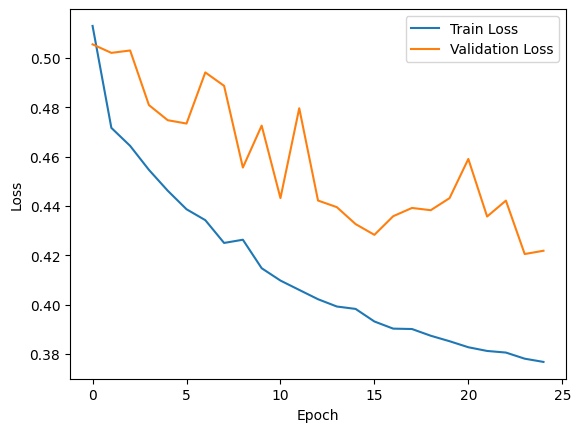

In [ ]:
plt.plot(train_history['loss'], label='Train Loss')
plt.plot(val_history['loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

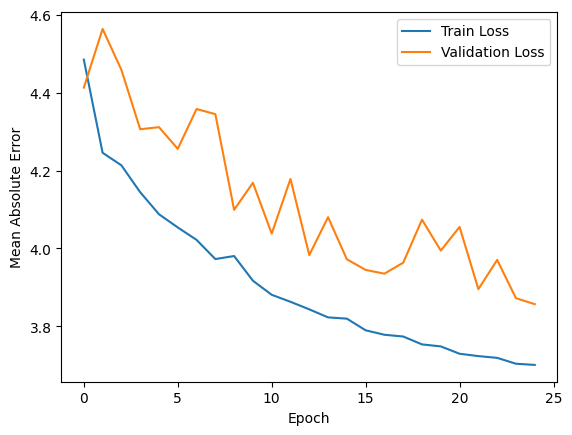

In [ ]:
plt.plot(train_history['mae'], label='Train MAE')
plt.plot(val_history['mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

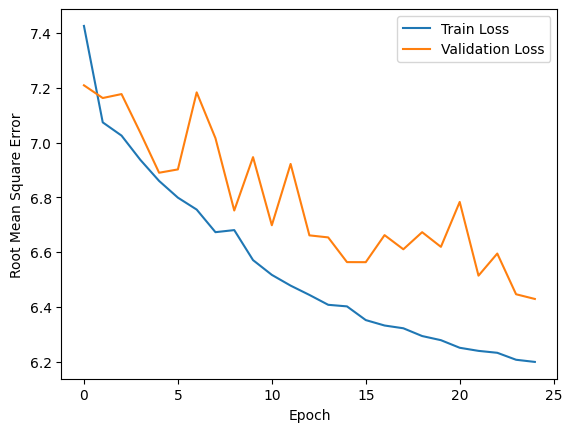

In [ ]:
plt.plot(train_history['rmse'], label='Train RMSE')
plt.plot(val_history['rmse'], label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Square Error')
plt.legend()
plt.show()

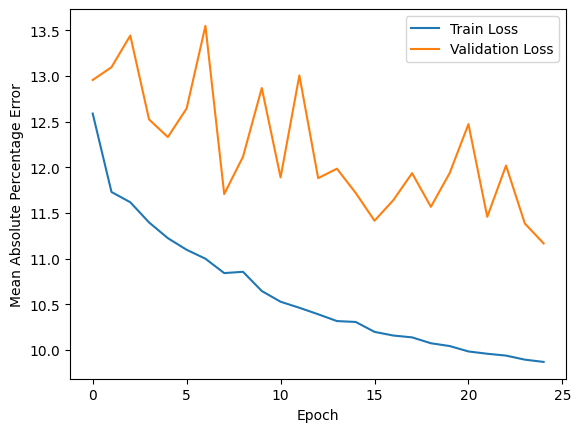

In [ ]:
plt.plot(train_history['mape'], label='Train MAPE')
plt.plot(val_history['mape'], label='Validation MAPE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Percentage Error')
plt.legend()
plt.show()

Saving model

In [ ]:
torch.save(model.state_dict(), "model.pt")

# Testing model performance

Processing batch...: 100%|██████████| 27/27 [00:18<00:00,  1.48it/s]


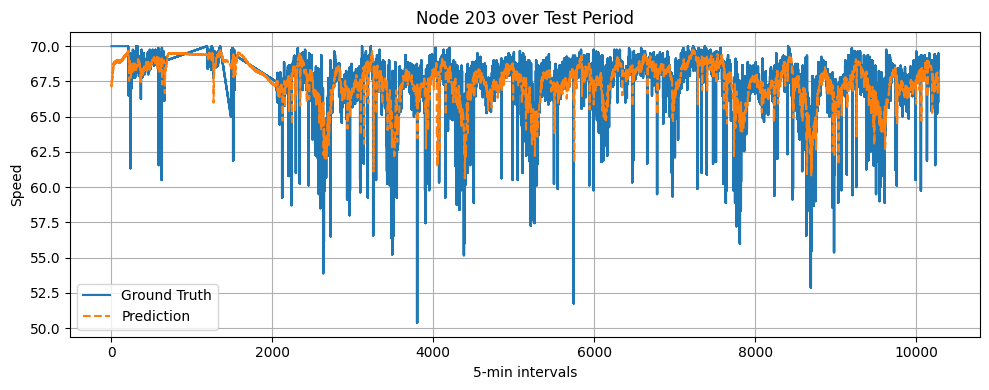

MAE: 3.8531  RMSE: 6.6891  MAPE: 10.7387


In [25]:
def test_metrics(test_loader):
    model.eval()

    total_mae = 0
    total_rmse = 0
    total_mape = 0
    samples = 0

    all_preds = []
    all_targs = []

    with torch.no_grad():
        for data_batch, target_batch in tqdm(test_loader, desc="Processing batch..."):
            # prepare and predict
            graphs = [g.to(device) for seq in data_batch for g in seq]
            batched = Batch.from_data_list(graphs)
            preds = model(batched, batch_size=len(data_batch))         # (B,207,3)
            targs = target_batch.permute(0,2,1).to(device)             # (B,207,3)

            # metrics
            mae, rmse, mape, b = compute_metrics(preds, targs)
            total_mae  += mae
            total_rmse += rmse
            total_mape += mape
            samples    += b

            all_preds.append(preds.cpu())
            all_targs.append(targs.cpu())

    # concatenate full test set
    preds = torch.cat(all_preds, dim=0).numpy()   # (N,207,3)
    targs = torch.cat(all_targs, dim=0).numpy()  # (N,207,3)

    # bring horizon into axis=1, flatten for scaler if needed:
    flat_preds = preds.transpose(0,2,1).reshape(-1, 3*207)   # (N*3,207)
    flat_targs = targs.transpose(0,2,1).reshape(-1, 3*207)

    # inverse scale here if you uncomment:
    flat_preds = y_scaler.inverse_transform(flat_preds)
    flat_targs = y_scaler.inverse_transform(flat_targs)

    # reshape back to (N,207,3)
    up_preds = flat_preds.reshape(-1,3,207).transpose(0,2,1)
    up_targs = flat_targs.reshape(-1,3,207).transpose(0,2,1)

    # finally flatten into continuous series: (N,207,3) -> (N*3,207)
    preds_flat = up_preds.transpose(0,2,1).reshape(-1,207)
    targs_flat = up_targs.transpose(0,2,1).reshape(-1,207)

    # plot sensor
    node = 203
    plt.figure(figsize=(10,4))
    plt.plot(targs_flat[:, node], label="Ground Truth")
    plt.plot(preds_flat[:, node], '--', label="Prediction")
    plt.title(f"Node {node} over Test Period")
    plt.xlabel("5-min intervals")
    plt.ylabel("Speed")
    plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.show()

    return total_mae/samples, total_rmse/samples, total_mape/samples

mae, rmse, mape = test_metrics(test_loader)
print(f"MAE: {mae:.4f}  RMSE: {rmse:.4f}  MAPE: {mape:.4f}")
